# Code summary

This notebook will explain the reccomended pre-processing og the jet consitituents of the ATLAS top-tagging dataset at https://opendata.cern.ch/record/80030.

We will assume you are familiar with the inspect_inputs.ipynb notebook already and will skip the explanantion on the file format and how to access the data. 

## Acessing the data

Exactly as before, lets download an input file to inspect

In [1]:
import sys,os
if not(os.path.isfile("train_nominal_000.h5")):
    if sys.platform=="darwin": #MAC OSX
        !curl https://opendata.cern.ch/record/80030/files/assets/atlas/datascience/CERN-EP-2024-159/train_nominal_000.h5.gz --output train_nominal_000.h5.gz
    elif sys.platform == "linux" or sys.platform == "linux2":
        !wget https://opendata.cern.ch/record/80030/files/assets/atlas/datascience/CERN-EP-2024-159/train_nominal_000.h5.gz
    !gunzip -f train_nominal_000.h5.gz

And let's import some packages we will need

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import h5py
import numpy as np

As we saw in the previous notebook accessing the inputs via `h5py` is very simple

In [3]:
NConstituents=100

h5_file = h5py.File("./train_nominal_000.h5", 'r')
clus_E=h5_file['fjet_clus_E'][:,:NConstituents]
clus_eta=h5_file['fjet_clus_eta'][:,:NConstituents]
clus_phi=h5_file['fjet_clus_phi'][:,:NConstituents]
clus_pt=h5_file['fjet_clus_pt'][:,:NConstituents]

print(clus_pt.shape)

(100000, 100)


## First look at the results

So let's start by plotting a scatter plot where of the eta/phi plain of the consituents, where the colour is a heatmap of their pt. Let's look at just first 1000 for now

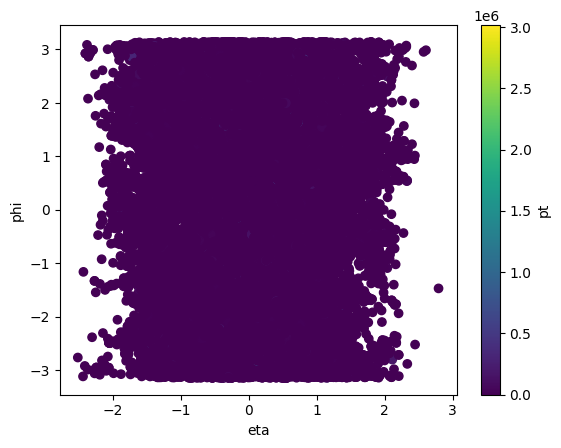

In [4]:
Njets=1000
plt.scatter(clus_eta[:Njets],clus_phi[:Njets],c=clus_pt[:Njets])
plt.xlabel('eta')
plt.ylabel('phi')
plt.colorbar(label='pt')

Okay that's a bit of a mess, but that is because all the jet and constituent information in regards to the 4-vectors are directly as those from the original reconstruction algorithm. So it makes sense the coverage is that of the whole detector if you just plot all the eta/phis.

Let's zoom in on a closer look and just plot a single jet

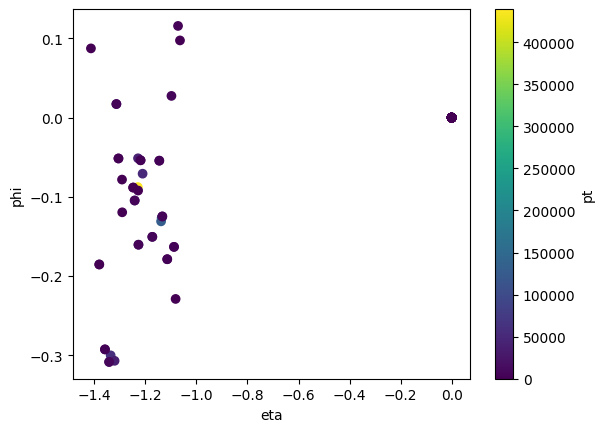

In [5]:
plt.scatter(clus_eta[0],clus_phi[0],c=clus_pt[0])
plt.xlabel('eta')
plt.ylabel('phi')
plt.colorbar(label='pt')

Okay looking better! But actually one thing you can also spot is that there is a bunch of consituents far away from the jet at (eta,phi)=(0,0). These are the zero padded jets

Let's mask these out at least

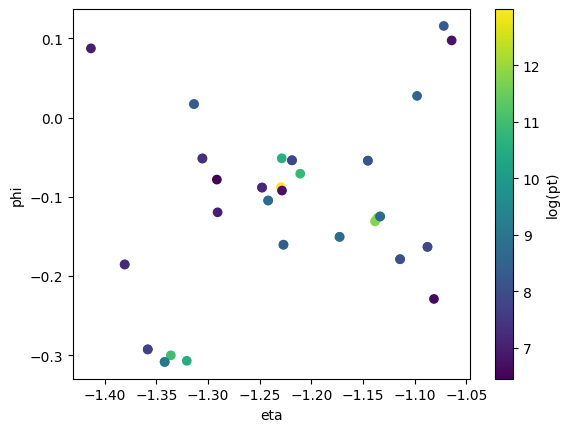

In [6]:
#make a mask for the first jet for non-zero jets
mask = np.asarray(clus_pt[0] > 0)

#Make new arrays applying the mask
eta=clus_eta[0][mask]
phi=clus_phi[0][mask]
pt=clus_pt[0][mask]
energy=clus_E[0][mask]

#Plot
plt.scatter(eta,phi,c=np.log(pt))
plt.xlabel('eta')
plt.ylabel('phi')
plt.colorbar(label='log(pt)')

Okay now we are getting somewhere as this is starting to look like a jet image.

## Preprocessing the data

You of course don't want your machine learning tagger to learn topology based features of your chosen training sample, or even detector features necessarily, so it is usually useful to preprocess such images to something more robust. The same is also true for unneccesary degrees of freedom of an arbitray jet image (like rotation), which can slow down machine learning training.

Majority of the following is copied from Kevin Grief's code which suplements the ATLAS open data https://gitlab.cern.ch/atlas/ATLAS-top-tagging-open-data/-/blob/master/utils.py?ref_type=heads#L21

We will go through this step by step.

First let's do a coordinate transform so that the (eta,phi)=(0,0) corresponds to the hardest constituent

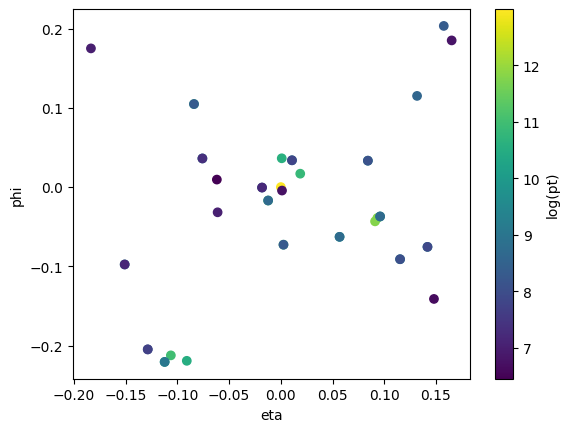

In [7]:
# 1. Center hardest constituent in eta/phi plane. First find eta and
# phi shifts to be applied
eta_shift = eta[0]
phi_shift = phi[0]

# Apply them using np.newaxis
eta -= eta_shift[np.newaxis]
phi -= phi_shift[np.newaxis]

# Fix discontinuity in phi at +/- pi using np.where
phi = np.where(phi > np.pi, phi - 2*np.pi, phi)
phi = np.where(phi < -np.pi, phi + 2*np.pi, phi)

#Plot
plt.scatter(eta,phi,c=np.log(pt))
plt.xlabel('eta')
plt.ylabel('phi')
plt.colorbar(label='log(pt)')

Looking good! Now let's rotate the jet so that second leading consitituent is on the phi axis

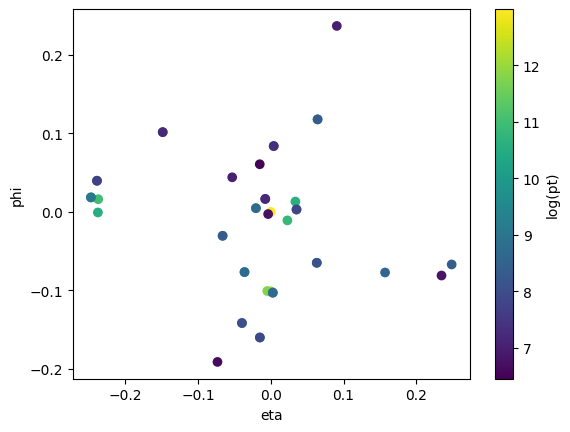

In [8]:
# 2. Rotate such that 2nd hardest constituent sits on negative phi axis
second_eta = eta[1]
second_phi = phi[1]
alpha = np.arctan2(second_phi, second_eta) + np.pi/2
eta_rot = (eta * np.cos(alpha[np.newaxis]) +
           phi * np.sin(alpha[np.newaxis]))
phi_rot = (-eta * np.sin(alpha[np.newaxis]) +
           phi * np.cos(alpha[np.newaxis]))
eta = eta_rot
phi = phi_rot

#Plot
plt.scatter(eta,phi,c=np.log(pt))
plt.xlabel('eta')
plt.ylabel('phi')
plt.colorbar(label='log(pt)')

Lastly let's do a possible third reflection so the 3rd consitituent is on the eta axis

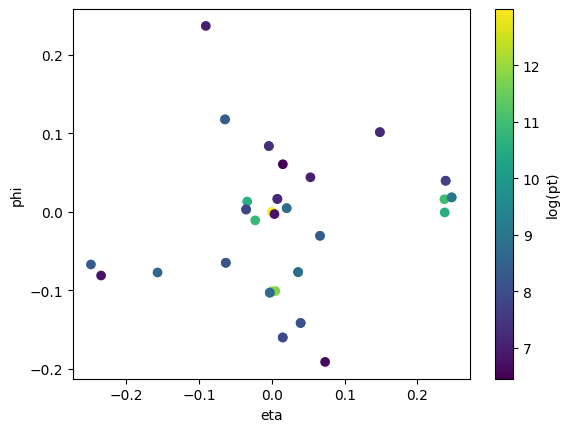

In [9]:
# 3. If needed, reflect so 3rd hardest constituent is in positive eta
third_eta = eta[2]
parity = np.where(third_eta < 0, -1, 1)
eta = (eta * parity[np.newaxis]).astype(np.float32)
# Cast to float32 needed to keep numpy from turning eta to double precision

#Plot
plt.scatter(eta,phi,c=np.log(pt))
plt.xlabel('eta')
plt.ylabel('phi')
plt.colorbar(label='log(pt)')

## Bulk preprocessing

Now we'll repeat the procedure for some bulk reprocessing, which is probably what you would want to do anyways

In [10]:
eta=clus_eta
phi=clus_phi
pt=clus_pt
energy=clus_E

In [11]:
# Find location of zero pt entries in each jet. This will be used as a
# mask to re-zero out entries after all preprocessing steps
mask = np.asarray(pt == 0).nonzero()

########################## Angular Coordinates #############################

# 1. Center hardest constituent in eta/phi plane. First find eta and
# phi shifts to be applied
eta_shift = eta[:,0]
phi_shift = phi[:,0]

# Apply them using np.newaxis
eta -= eta_shift[:,np.newaxis]
phi -= phi_shift[:,np.newaxis]

# Fix discontinuity in phi at +/- pi using np.where
phi = np.where(phi > np.pi, phi - 2*np.pi, phi)
phi = np.where(phi < -np.pi, phi + 2*np.pi, phi)

# 2. Rotate such that 2nd hardest constituent sits on negative phi axis
second_eta = eta[:,1]
second_phi = phi[:,1]
alpha = np.arctan2(second_phi, second_eta) + np.pi/2
eta_rot = (eta * np.cos(alpha[:,np.newaxis]) +
           phi * np.sin(alpha[:,np.newaxis]))
phi_rot = (-eta * np.sin(alpha[:,np.newaxis]) +
           phi * np.cos(alpha[:,np.newaxis]))
eta = eta_rot
phi = phi_rot

# 3. If needed, reflect so 3rd hardest constituent is in positive eta
third_eta = eta[:,2]
parity = np.where(third_eta < 0, -1, 1)
eta = (eta * parity[:,np.newaxis]).astype(np.float32)
# Cast to float32 needed to keep numpy from turning eta to double precision

########################### Finalize and Return ############################

# Reset all of the original zero entries to zero
eta[mask] = 0
phi[mask] = 0
pt[mask] = 0
energy[mask] = 0

That's probably all you want, but let's make one last image averaged plot for signal jets

In [12]:
#Mask to only signal jets
labels=h5_file["labels"][:]
mask = np.asarray(labels==1)

sig_pt=pt[mask]
sig_phi=phi[mask]
sig_eta=eta[mask]

#Mask zero pt
mask = np.asarray(sig_pt >0)
sig_pt=sig_pt[mask]
sig_eta=sig_eta[mask]
sig_phi=sig_phi[mask]

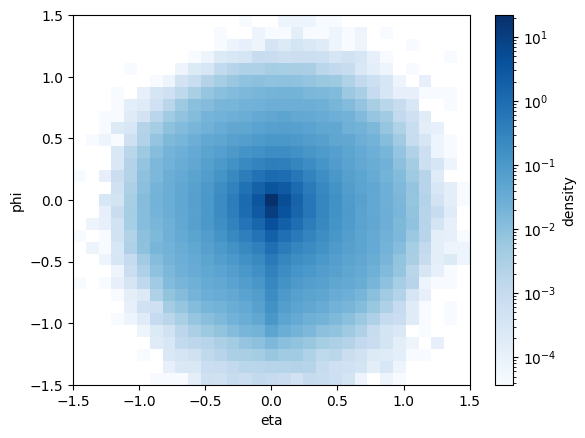

In [13]:
#make a 2D density histogram of the average jet
plt.hist2d(sig_eta,sig_phi,range=[[-1.5,1.5],[-1.5,1.5]],bins=[31,31],cmap="Blues",density=True,norm=mpl.colors.LogNorm())
plt.xlabel('eta')
plt.ylabel('phi')
plt.colorbar(label="density")

So nice